In [1]:
import torch
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from label_dict import protein_to_num_single_cells, protein_to_num_full
from tqdm import tqdm
from scipy.stats import ttest_ind, zscore, norm
from statsmodels.stats.weightstats import ztest as ztest
from skimage import io
from matplotlib import cm

In [19]:
cmap = cm.nipy_spectral

def get_embeddings(features):
    scaled_features = StandardScaler().fit_transform(features.numpy())
    reducer = UMAP(init='random', random_state=42)
    embedding = reducer.fit_transform(scaled_features)
    return embedding

def plot_UMAP(df, labels, embedding, title):
    mat, labels = get_col_matrix(df, labels)
    plt.figure(figsize=(10,10))
    for i in range(mat.shape[1]):
        indices = np.where(mat[:, i])[0]
        plt.scatter(embedding[indices, 0], 
                    embedding[indices, 1],
                    s=0.1,
                    label=labels[i],
                    color=cmap(i / mat.shape[1])
                   )
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title(title, fontsize=30)
    lgnd = plt.legend(bbox_to_anchor=(1,1))
    for h in lgnd.legendHandles:
        h._sizes = [30]

def get_col_matrix(df, labels):
    if len(labels) == 1:
        values = df[labels[0]]
        unique_values = sorted(np.unique(values))
        mat = np.zeros((len(df), len(unique_values)))
        for ind, value in enumerate(unique_values):
            mat[np.where(values == value)[0], ind] = 1
        columns = unique_values
    else:
        mat = df[sorted(labels)].values.astype(int)
        columns = sorted(labels)
    return mat, columns

def get_averaged_features(df, features, labels):
    mat, columns = get_col_matrix(df, labels)
    averaged_features = []
    for key in range(len(columns)):
        indices = np.where(mat[:,key])
        averaged_features.append(features[indices].mean(axis=0))
    averaged_features = torch.stack(averaged_features)
    return averaged_features, columns

def get_heirarchical_clustering(df, features, labels):
    averaged_features, columns = get_averaged_features(df, features, labels)
    distance_matrix = cosine_similarity(averaged_features, averaged_features)
    Z = linkage(distance_matrix)
    plt.figure(figsize=(20,5))
    dn = dendrogram(Z, labels = columns)
    plt.xticks(rotation=45)
    distance_matrix = distance_matrix[dn['leaves'], :][:, dn['leaves']]
    columns = dn['ivl']
    plt.figure(figsize=(10,10))
    plt.imshow(distance_matrix)
    plt.xticks(range(len(columns)), columns, rotation=90)
    plt.yticks(range(len(columns)), columns)
    return distance_matrix, columns

def get_heterogeneousity_per_whole_image(df, features, indices, metric='distance', verbose=False):
    cells_per_ID = df.iloc[indices].groupby('ID').groups
    mean_distances_per_ID = []
    for ID in tqdm(sorted(cells_per_ID.keys()), disable=verbose == False):
        if metric == 'distance':
            distance_matrix = cosine_distances(features[cells_per_ID[ID]], 
                                                features[cells_per_ID[ID]])
            distances = np.triu(distance_matrix)[np.triu_indices(distance_matrix.shape[0], k=1)]
            if len(distances) == 0: continue
            mean_distances_per_ID.append(distances.mean())
        elif metric == 'std':
            mean_distances_per_ID.append(features[cells_per_ID[ID]].std(axis=0).mean().item())
    return mean_distances_per_ID, sorted(cells_per_ID.keys())

def get_heterogeneousity_per_gene(merged_df, features, indices, metric='distance', verbose=False):
    cells_per_gene = merged_df.iloc[indices].groupby(['Gene','cell_type']).groups
    keys = sorted(cells_per_gene.keys())
    mean_distances_per_ID = []
    for gene in tqdm(keys):
        if metric == 'distance':
            distance_matrix = cosine_distances(features[merged_df.iloc[cells_per_gene[gene]].original_index.values], 
                                                features[merged_df.iloc[cells_per_gene[gene]].original_index.values])
            distances = np.triu(distance_matrix)[np.triu_indices(distance_matrix.shape[0], k=1)]
            if len(distances) == 0: continue
            mean_distances_per_ID.append(distances.mean())
        elif metric == 'std':
            mean_distances_per_ID.append(features[merged_df.iloc[cells_per_gene[gene]].original_index.values].std(axis=0).mean().item())
    return mean_distances_per_ID, keys

def plot_heterogeneity(mean_distances_hetero, mean_distances_homo):
    p_value = ttest_ind(mean_distances_hetero, mean_distances_homo)[1]
    plt.figure(figsize=(5,5))
    plt.hist(mean_distances_hetero, alpha=0.5, density=True, bins=np.linspace(0, 1, 100), label='Heterogeneous')
    plt.hist(mean_distances_homo, alpha=0.5, density=True, bins=np.linspace(0, 1, 100), label='Homorogeneous')
    plt.legend(frameon=False)
    plt.xlabel('Mean feature distances within whole image')
    plt.ylabel('Density')
    plt.title(f'p-value={p_value:0.1}')
    
    plt.figure(figsize=(5,5))
    plt.errorbar(0, np.mean(mean_distances_hetero), yerr=np.std(mean_distances_hetero), fmt="o", capsize=5)
    plt.errorbar(1, np.mean(mean_distances_homo), yerr=np.std(mean_distances_homo), fmt="o", capsize=5)
    plt.axis([-0.5, 1.5, 
              np.mean(mean_distances_hetero) - np.std(mean_distances_hetero) - 0.1, 
              np.mean(mean_distances_hetero) + np.std(mean_distances_hetero) + 0.1])
    plt.xticks([0,1],['Heterogeneous','Homogeneous'])
    plt.ylabel('Mean feature distances within whole image')
    plt.title(f'p-value={p_value:0.1}')    

def generate_all_figures(config_file, labels = protein_to_num_full):
    config = yaml.safe_load(open(config_file, "r"))
    df = pd.read_csv(config['embedding']['df_path'])
    features, protein_localizations, cell_lines, IDs = torch.load(config['embedding']['output_path'])    
    embedding = get_embeddings(features)  
    heterogeneity_df = get_heterogeneity_df()

    heterogeneity_key = 'v_spatial'
    heterogeneous_indices = np.where(df.ID.isin(heterogeneity_df[heterogeneity_df[heterogeneity_key]].ID))[0]
    homogeneous_indices = np.where(df.ID.isin(heterogeneity_df[heterogeneity_df[heterogeneity_key]].ID) == False)[0]
    scaled_features = StandardScaler().fit_transform(features.numpy())
    mean_distances_hetero = get_heterogeneousity_per_whole_image(df, scaled_features, heterogeneous_indices, metric='distance', verbose=False)
    mean_distances_homo = get_heterogeneousity_per_whole_image(df, scaled_features, homogeneous_indices, metric='distance', verbose=False)
    mean_stds_hetero = get_heterogeneousity_per_whole_image(df, scaled_features, heterogeneous_indices, metric='std', verbose=False)
    mean_stds_homo = get_heterogeneousity_per_whole_image(df, scaled_features, homogeneous_indices, metric='std', verbose=False)
    distance_matrix, columns = get_heirarchical_clustering(df, features, ['cell_type'])    
    distance_matrix, columns = get_heirarchical_clustering(df, features, labels)
    plot_UMAP(df, ['cell_type'], embedding, 'Cell line')
    plot_UMAP(df, labels, embedding, 'Protein localization')
    plot_heterogeneity(mean_distances_hetero, mean_distances_homo)
    plot_heterogeneity(mean_stds_hetero, mean_stds_homo)

def get_heterogeneity_df():
    HPA_img_df = pd.read_csv('/scr/mdoron/Dino4Cells/data/HPA_img_df.csv')
    HPA_img_df['ID'] = HPA_img_df.img_file.apply(lambda x:'_'.join(x.split('/')[-2:]).split('_blue')[0])
    HPA_img_df['Gene'] = HPA_img_df['gene']
    proto_heterogeneity_df = pd.read_csv('/scr/mdoron/Dino4Cells/data/gene_heterogeneity.tsv', delimiter='\t')
    proto_heterogeneity_df['v_spatial'] = proto_heterogeneity_df['Single-cell variation spatial']
    proto_heterogeneity_df['v_intensity'] = proto_heterogeneity_df['Single-cell variation intensity']
    proto_heterogeneity_df['HPA_variable'] = np.nan
    proto_heterogeneity_df.loc[(pd.isnull(proto_heterogeneity_df['v_intensity']) == False),'v_intensity'] = True
    proto_heterogeneity_df.loc[(pd.isnull(proto_heterogeneity_df['v_intensity'])),'v_intensity'] = False
    proto_heterogeneity_df.loc[(pd.isnull(proto_heterogeneity_df['v_spatial']) == False),'v_spatial'] = True
    proto_heterogeneity_df.loc[(pd.isnull(proto_heterogeneity_df['v_spatial'])),'v_spatial'] = False
    proto_heterogeneity_df.loc[(proto_heterogeneity_df['v_spatial']) | (proto_heterogeneity_df['v_intensity']), 'HPA_variable'] = True
    heterogeneity_df = pd.merge(proto_heterogeneity_df, HPA_img_df, on='Gene')[['Gene','ID','v_spatial','v_intensity','HPA_variable', 'cell_type']]
    return heterogeneity_df


In [34]:
config_file = '/scr/mdoron/Dino4Cells/configs/config_r_A549.yaml'
config = yaml.safe_load(open(config_file, "r"))
features_r, protein_localizations, cell_lines, IDs = torch.load(config['embedding']['output_path'])    
config_file = '/scr/mdoron/Dino4Cells/configs/config_g_A549.yaml'
config = yaml.safe_load(open(config_file, "r"))
features_g, protein_localizations, cell_lines, IDs = torch.load(config['embedding']['output_path'])    
config_file = '/scr/mdoron/Dino4Cells/configs/config_b_A549.yaml'
config = yaml.safe_load(open(config_file, "r"))
features_b, protein_localizations, cell_lines, IDs = torch.load(config['embedding']['output_path'])    
config_file = '/scr/mdoron/Dino4Cells/configs/config_y_A549.yaml'
config = yaml.safe_load(open(config_file, "r"))
features_y, protein_localizations, cell_lines, IDs = torch.load(config['embedding']['output_path'])    
df = pd.read_csv(config['embedding']['df_path'])


In [35]:
features = torch.concat([features_r,
                         features_g,
                        features_b,
                        features_y], axis=1)


In [36]:
embedding = get_embeddings(features_g)  


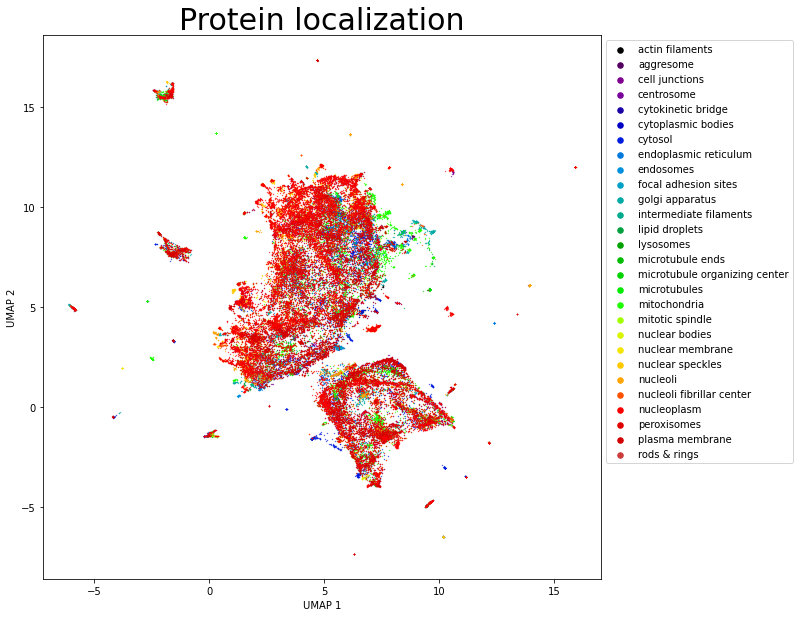

In [38]:
plot_UMAP(df, protein_to_num_full, embedding, 'Protein localization')


In [39]:
embedding = get_embeddings(features_g)  


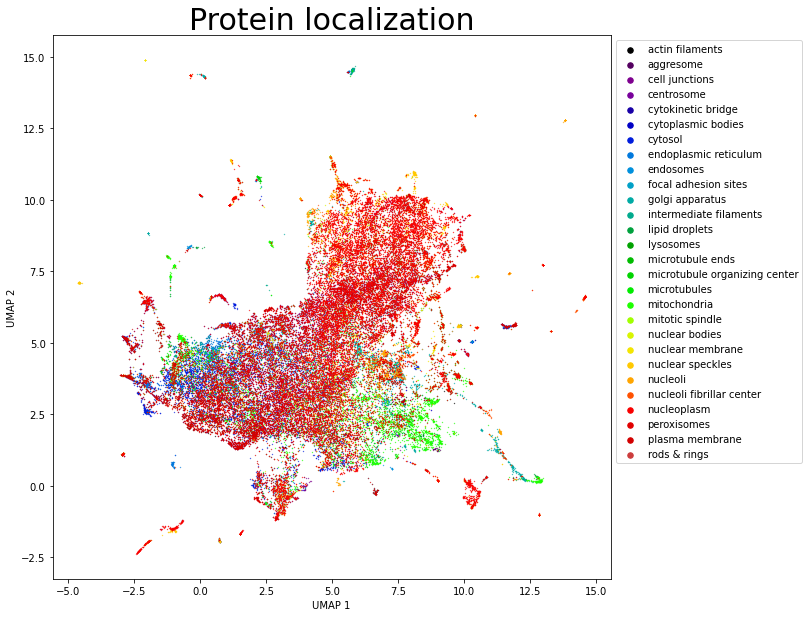

In [41]:
plot_UMAP(df, protein_to_num_full, embedding, 'Protein localization')


In [44]:
features, protein_localizations, cell_lines, IDs = torch.load('/scr/mdoron/Dino4Cells//exp02_reproduction/features.pth')    
embedding = get_embeddings(features)  

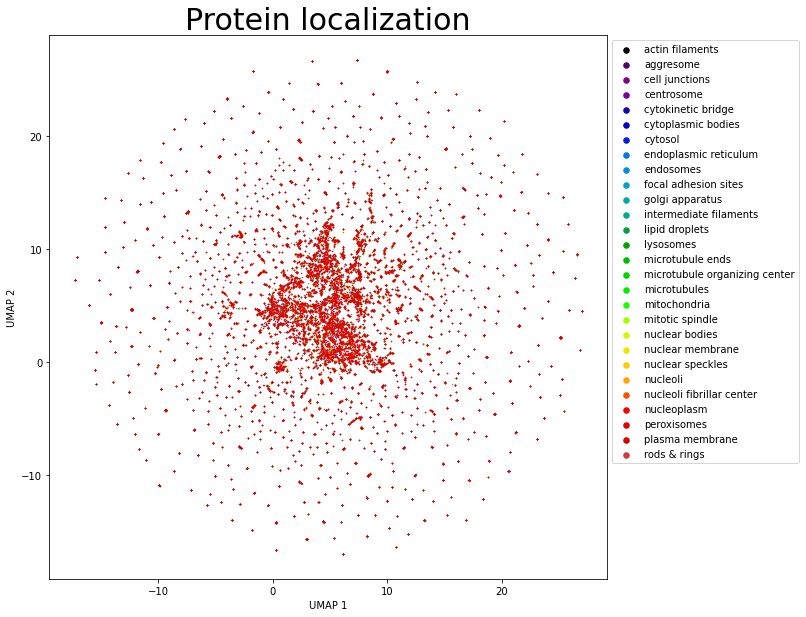

In [46]:
plot_UMAP(df, protein_to_num_full, embedding, 'Protein localization')


In [53]:
features, protein_localizations, cell_lines, IDs = torch.load('/scr/mdoron/Dino4Cells/models/pretrained_A549/f)    
embedding = get_embeddings(features)  

In [54]:
plot_UMAP(df, protein_to_num_full, embedding, 'Protein localization')


ValueError: On entry to DHSEQR parameter number 4 had an illegal value

<Figure size 720x720 with 1 Axes>

In [51]:
embedding.shape

(629694, 2)

In [70]:
df.columns

Index(['Unnamed: 0', 'file', 'ID', 'cell_type',
       'actin filaments,focal adhesion sites', 'aggresome',
       'centrosome,centriolar satellite', 'cytosol', 'endoplasmic reticulum',
       'golgi apparatus', 'intermediate filaments', 'microtubules',
       'mitochondria', 'mitotic spindle', 'no staining', 'nuclear bodies',
       'nuclear membrane', 'nuclear speckles', 'nucleoli',
       'nucleoli fibrillar center', 'nucleoplasm',
       'plasma membrane,cell junctions',
       'vesicles,peroxisomes,endosomes,lysosomes,lipid droplets,cytoplasmic bodies'],
      dtype='object')

In [62]:
df = pd.read_csv('data/fixed_size_masked_single_cells_for_sc.csv')


In [66]:
u2os_df = df[df.cell_type == 'U-2 OS']

In [72]:
u2os_df = u2os_df.reset_index()[['file', 'ID', 'cell_type',
       'actin filaments,focal adhesion sites', 'aggresome',
       'centrosome,centriolar satellite', 'cytosol', 'endoplasmic reticulum',
       'golgi apparatus', 'intermediate filaments', 'microtubules',
       'mitochondria', 'mitotic spindle', 'no staining', 'nuclear bodies',
       'nuclear membrane', 'nuclear speckles', 'nucleoli',
       'nucleoli fibrillar center', 'nucleoplasm',
       'plasma membrane,cell junctions',
       'vesicles,peroxisomes,endosomes,lysosomes,lipid droplets,cytoplasmic bodies']]

In [73]:
u2os_df.to_csv('data/u2os_df.csv', index=False)